# ADL HW1
# Ruoheng Du (rd3165)

### Imports



In [7]:
!pip install torchviz

In [8]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
seed = 1
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
set_seed(1)

In [13]:
#Change your runtime type to a GPU to activate "cuda" as a device - will make your code so much faster
device = "cuda" if torch.cuda.is_available() else "cpu"

## The XOR Problem in PyTorch

In lecture, we talked about a barrier to the development of neural networks - **the XOR problem**.

We are now going to show how to solve this in PyTorch! Let's first generate the data.

In [9]:
# Setting a seed to make reproducible results
np.random.seed(seed)
torch.manual_seed(seed)

# Generate two random features as 0/1 (indicator variables)
x1 = (np.random.uniform(size=200) < 0.5).astype(int)
x2 = (np.random.uniform(size=200) < 0.5).astype(int)

# Creating the dataset from the features
x = np.array([x1, x2]).T

# Setting up XOR formula
y = x1 + x2 - 2 * x1 * x2

# Train and test split - use some of the data to train the neural network and
# the rest to validate our results
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.long)
x_test = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_test = torch.tensor(y[n_train:], dtype=torch.long)

# Visualizing our data (adding some jitter)
# fig = plt.figure(figsize=(6, 6))
# x_jittered = x + np.random.normal(scale=0.009, size=x.shape)
# plt.plot(x_jittered[y==0, 0],
#          x_jittered[y==0, 1], 'o', alpha=0.5, markersize=10, c='#8b0000')
# plt.plot(x_jittered[y==1, 0],
#          x_jittered[y==1, 1], '<', alpha=0.5, markersize=10, c='#234f1e')
# plt.xlabel(r'$x_1$', size=15)
# plt.ylabel(r'$x_2$', size=15)

# plt.show()

Now, let's start creating some models to test their ability to solve the XOR problem.

We need to set some hyperparameters first...

In [21]:
# Hyperparameters
input_size = 2 # How many features do we have?
output_size = 2 # 2 signifies binary classification
lr = 0.05 # Factor we will multiply our gradients by in SGD, how much we want to let what we learn change our model parameters
batch_size = 2 # How many examples do you want look at on each update?

In [22]:
# Creating TensorDataset and DataLoader objects from our data
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

# DataLoader allows efficient iteration over data in batches
# - train_dl shuffles the training data to prevent any overfitting
# - test_dl does not shuffle the test data so it is in its original order
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

### Adding Non-Linearity to our Model

Let us use a **multilayer perceptron with non-linearity** to see how this does!

In [23]:
# Creating our MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MultiLayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList([ # Accomplishes the same thing but less code
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, x):
        for layer in self.module_list: # Accomplishes the same thing but less code
            x = layer(x)
        return x

MLP = MultiLayerPerceptron(input_size, output_size, 2).to(device)
MLP

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [24]:
# Resetting our variables!
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(MLP.parameters(), lr=lr)
losses = []

# Training loop
for epoch in range(100):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    zero_gradients_count = 0

    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        zero_gradients = sum((p.grad == 0).sum().item() for p in MLP.parameters() if p.grad is not None)
        zero_gradients_count += zero_gradients

        optimizer.step()

        total_loss += loss.item()

        predictions = outputs.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    losses.append(avg_loss)
    avg_zero_gradients = zero_gradients_count / len(train_dl)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss}, Zero Gradients: {avg_zero_gradients}")

print("--------------")
print(f"Train Accuracy: {correct_predictions / total_samples}")

Epoch 0, Loss: 0.3489470785856247, Zero Gradients: 3.8
Epoch 10, Loss: 0.34402575105428695, Zero Gradients: 5.6
Epoch 20, Loss: 0.27592690885066984, Zero Gradients: 5.5
Epoch 30, Loss: 0.024150825068354607, Zero Gradients: 5.54
Epoch 40, Loss: 0.009141817316412925, Zero Gradients: 5.72
Epoch 50, Loss: 0.005446247169747949, Zero Gradients: 5.76
Epoch 60, Loss: 0.003833148975390941, Zero Gradients: 5.7
Epoch 70, Loss: 0.002941601846832782, Zero Gradients: 5.86
Epoch 80, Loss: 0.0023783823440317064, Zero Gradients: 5.5
Epoch 90, Loss: 0.001991626841481775, Zero Gradients: 5.66
--------------
Train Accuracy: 1.0


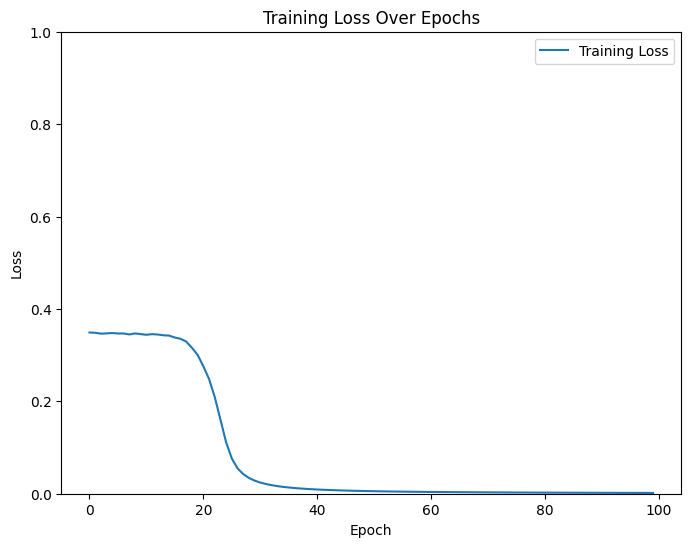

In [25]:
# Plotting the MLP training loss
plt.figure(figsize=(8, 6))
plt.plot(range(100), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [26]:
# Set model to evaluation mode
MLP.eval()

# Initialize a counters for correct and total predictions
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)

        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)


# Calculate accuracy
accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 100.00%
